In [200]:
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt
import json
from datetime import datetime, timedelta
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

In [201]:
# 字符串转int数组，且处理空值
def parse_str_to_int(input_string):
    parts = input_string.split(',')
    int_list = [int(part) if part.strip() else 0 for part in parts]
    return int_list  

# 按照日期段，匹配数据和时间点
def group_data_df(input_string, start_date, end_date):
    data_points = parse_str_to_int(input_string)
    total_days = (pd.to_datetime(end_date) - pd.to_datetime(start_date)).days
    num_points = len(data_points) 
    interval = total_days / (num_points - 1)
    time_points = pd.date_range(start=start_date, periods=num_points, freq=f"{interval:.2f}D")

    df = pd.DataFrame({
        'Date': time_points,
        'Value': data_points
    })
    return df

# 按照年份聚合数据
def group_data_by_year(input_string, start_date, end_date):
    df = group_data_df(input_string, start_date, end_date)
    df['Year'] = df['Date'].dt.year
    yearly_data = df.groupby('Year')['Value'].sum().reset_index()
    yearly_data_pivot = yearly_data.pivot_table(index=None, columns='Year', values='Value')
    yearly_data_pivot.columns.name = None
    yearly_data_pivot = yearly_data_pivot.reset_index(drop=True)
    return yearly_data_pivot

In [202]:
df = pd.read_csv('./data/search_index_all.csv')
cities = pd.read_csv('./data/study_cities.csv')['name'].tolist()

## 年度趋势

In [203]:
def output_yearly():
    dfs = []
    for city in cities:
        df_city = df[df.city==city]
        for i, r in df_city.iterrows():
            y = group_data_by_year(r['total'], r['start_date'], r['end_date'])
            y['city'] = city
            y['keyword'] = r['keyword']
            dfs.append(y)

    temp = pd.concat(dfs)
    columns_order = ['city', 'keyword'] + list(temp.columns[:-2])
    temp = temp[columns_order]
    temp = temp.reset_index(drop=True)
    temp.to_csv('./R/time_city_keyword_yearly.csv', index=None)
    return temp

output_yearly()

,city,keyword,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,济南市,低碳,1994.0,2073.0,2011.0,1836.0,1988.0,2178.0,2924.0,3522.0,3038.0,1913.0,811.0
1,济南市,低碳出行,567.0,759.0,1699.0,1737.0,1777.0,1394.0,1596.0,1623.0,1035.0,782.0,259.0
2,济南市,低碳饮食,57.0,90.0,369.0,1169.0,1835.0,2111.0,2297.0,1745.0,705.0,326.0,239.0
3,济南市,低碳经济,1897.0,1415.0,1404.0,1115.0,1131.0,1215.0,1318.0,1572.0,1464.0,706.0,209.0
4,济南市,碳中和,89.0,114.0,66.0,160.0,323.0,2540.0,15329.0,10785.0,7585.0,6365.0,3870.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3625,澳门特别行政区,碳达峰,0.0,0.0,0.0,0.0,0.0,8.0,397.0,274.0,225.0,128.0,56.0
3626,澳门特别行政区,碳排放,0.0,0.0,16.0,80.0,32.0,112.0,177.0,251.0,235.0,98.0,40.0
3627,澳门特别行政区,碳足迹,0.0,0.0,56.0,48.0,56.0,40.0,142.0,195.0,64.0,114.0,33.0
3628,澳门特别行政区,碳交易,0.0,0.0,32.0,8.0,16.0,40.0,351.0,258.0,153.0,82.0,48.0


## 总体趋势

In [204]:
def summarize_by_city_year():
    temp = pd.read_csv('./R/time_city_keyword_yearly.csv')
    res = temp.groupby('city').sum(numeric_only=True).reset_index()
    res.to_csv('./R/time_city_yearly.csv', index=None)
    res.to_csv('./QGIS/time_city_yearly.csv', index=None)
    return res

summarize_by_city_year()

,city,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025
0,七台河市,48.0,64.0,32.0,105.0,50.0,104.0,1330.0,1220.0,498.0,401.0,257.0
1,万宁市,0.0,0.0,32.0,16.0,32.0,32.0,1033.0,737.0,212.0,218.0,72.0
2,三亚市,194.0,137.0,274.0,313.0,492.0,972.0,8015.0,6122.0,3094.0,2190.0,576.0
3,三明市,500.0,865.0,905.0,417.0,591.0,887.0,9461.0,7829.0,2983.0,2752.0,1230.0
4,三门峡市,285.0,208.0,315.0,717.0,386.0,809.0,6145.0,5138.0,2281.0,1702.0,1037.0
...,...,...,...,...,...,...,...,...,...,...,...,...
358,黔东南苗族侗族自治州,148.0,161.0,336.0,555.0,282.0,737.0,4244.0,4958.0,2634.0,3090.0,1015.0
359,黔南布依族苗族自治州,151.0,194.0,349.0,362.0,406.0,513.0,6055.0,7299.0,5100.0,2867.0,807.0
360,黔西南布依族苗族自治州,97.0,187.0,249.0,224.0,137.0,354.0,2811.0,2635.0,1488.0,1530.0,409.0
361,齐齐哈尔市,477.0,314.0,378.0,421.0,417.0,871.0,6792.0,6126.0,3396.0,2874.0,1186.0


In [205]:
def output_year_trend():
    temp = pd.read_csv('./R/time_city_yearly.csv')
    years = temp.columns[1:]
    yearly_totals = temp[years].sum()
    result_df = yearly_totals.reset_index()
    result_df.columns = ['year', 'total']  
    result_df.to_csv('./R/time_year_trend.csv', index=None)
    return result_df
output_year_trend()

,year,total
0,2015,508210.0
1,2016,451405.0
2,2017,590379.0
3,2018,645325.0
4,2019,686025.0
5,2020,994469.0
6,2021,4482848.0
7,2022,3952695.0
8,2023,2688708.0
9,2024,2089702.0


## 关键词分布

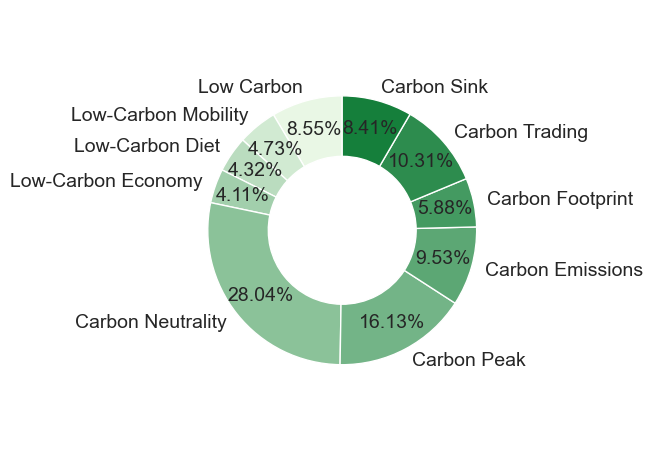

,keyword,keyword_en,attention
0,低碳,Low Carbon,1544526.0
1,低碳出行,Low-Carbon Mobility,855137.0
2,低碳饮食,Low-Carbon Diet,780129.0
3,低碳经济,Low-Carbon Economy,742526.0
4,碳中和,Carbon Neutrality,5067978.0
5,碳达峰,Carbon Peak,2914903.0
6,碳排放,Carbon Emissions,1721441.0
7,碳足迹,Carbon Footprint,1061931.0
8,碳交易,Carbon Trading,1863131.0
9,碳汇,Carbon Sink,1520775.0


In [206]:
def output_keyword_ratio():
    temp = pd.read_csv('./R/time_city_keyword_yearly.csv')
    keywords = pd.read_csv('./keywords_en.csv')
    years = temp.columns[2:]
    items = []
    for i, r in keywords.iterrows():
        filtered_df = temp[temp['keyword'] == r['keyword']]
        _sum = 0
        for y in years:
            _sum += filtered_df[y].sum()
        items.append([r['keyword'], r['en'], _sum])

    res = pd.DataFrame(items, columns=['keyword', 'keyword_en', 'attention'])
    res.to_csv('./R/keyword_ratio.csv', index=None)

    colors = LinearSegmentedColormap.from_list("custom_green", ["#E9F7E5", "#157F3B"], N=len(res))
    color_list = [colors(i) for i in range(len(res))]
    
    def custom_autopct(pct):
        return ('%1.2f%%' % pct) if pct > 0 else ''

    wedges, texts, autotexts = plt.pie(
        res['attention'],
        labels=res['keyword_en'],
        colors=color_list,
        autopct=custom_autopct,
        wedgeprops={'width': 0.45, 'edgecolor': 'white'},
        startangle=90,
        textprops={'fontsize': 14}
    )

    # Adjust the position of the percentage labels
    for autotext in autotexts:
        autotext.set_position((1.3 * autotext.get_position()[0], 1.3 * autotext.get_position()[1]))
        autotext.set_fontsize(14)

    plt.axis('equal')  
    plt.tight_layout()
    plt.savefig('./R/keyword_pie.pdf', format='pdf', bbox_inches='tight')
    plt.show()
    return res

output_keyword_ratio()

## 年份-关键词

In [207]:
def output_keyword_yearly():
    keywords = pd.read_csv('./keywords_en.csv')
    temp = pd.read_csv('./R/time_city_keyword_yearly.csv')
    years = temp.columns[2:]  
    aggregated_data = temp.groupby('keyword')[years].sum().reset_index()
    aggregated_data[years] = aggregated_data[years] / 1000
    merged_data = pd.merge(aggregated_data, keywords, on='keyword', how='left')
    merged_data.to_csv('./R/time_keyword_yearly.csv', index=None)

    # del merged_data['keyword']
    # res = merged_data[['en'] + list(years)]
    return merged_data

output_keyword_yearly()

,keyword,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024,2025,en
0,低碳,113.413,98.268,111.512,131.047,127.437,155.558,196.328,234.611,188.364,131.585,56.403,Low Carbon
1,低碳出行,27.926,34.993,81.935,113.699,106.078,117.249,118.420,115.477,76.812,45.129,17.419,Low-Carbon Mobility
2,低碳经济,118.238,77.803,58.917,61.064,63.340,94.732,76.824,86.947,57.484,35.555,11.622,Low-Carbon Economy
3,低碳饮食,4.928,5.035,26.916,82.032,138.354,141.686,146.740,118.694,65.190,32.900,17.654,Low-Carbon Diet
4,碳中和,8.257,8.267,9.309,11.976,22.506,186.542,1783.044,1348.044,820.872,596.712,272.449,Carbon Neutrality
5,碳交易,71.956,77.410,113.158,78.332,50.498,59.333,549.242,329.961,253.828,201.496,77.917,Carbon Trading
6,碳排放,64.872,68.300,77.766,71.844,67.349,86.308,375.203,373.985,238.217,213.039,84.558,Carbon Emissions
7,碳汇,40.647,43.748,79.361,55.231,59.733,72.546,281.150,323.111,263.680,205.069,96.499,Carbon Sink
8,碳足迹,57.973,37.581,31.505,40.100,50.730,63.779,124.732,175.508,170.902,167.641,141.480,Carbon Footprint
9,碳达峰,0.000,0.000,0.000,0.000,0.000,16.736,831.165,846.357,553.359,460.576,206.710,Carbon Peak
